1. Import libraries

In [1]:
import sys
sys.path.append('/content/drive/My Drive/object_pose_estimation_online')
from Classes.CameraCalibration import *
from google.colab.patches import cv2_imshow

2. Import all calibration images

In [2]:
# Get all image's path names
robot_camera_calibration_images_file = '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_*.jpg'
images_path_names = get_image_path_names(robot_camera_calibration_images_file)

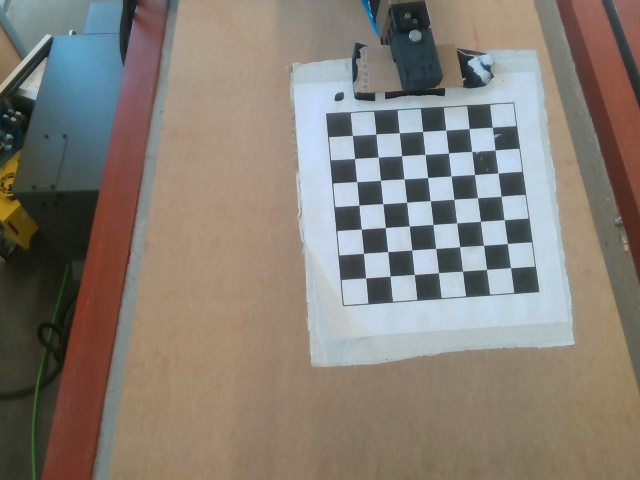

In [3]:
# Preview image
image_path = images_path_names[0]
image = read_image(image_path)
cv2_imshow(image)

3. Load baselink-target transformation matrices for 10 images

In [4]:
# Baselink-target trasnformations filename
baselink_target_transformations_file = '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/baselink_target_transformations.npy'

In [5]:
# Get all corresponding transformation matrices (numpy data)
baselink_target_transformations = get_numpy_data(baselink_target_transformations_file)
print(np.shape(baselink_target_transformations))

(10, 4, 4)


4. Load calculated intrinsic camera matrix

In [6]:
# Intrinsic camera matrix filename
intrinsic_camera_matrix_file = '/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/intrinsic_camera_properties.npz'

In [7]:
# Load intrinsic camera matrix and distortion coefficients
mtx, dist = load_intrinsic_camera_matrix(intrinsic_camera_matrix_file)

5. Camera-robot calibration

In [8]:
# Filepath to save baselink-camera transform
baselink_camera_transformation_file = '/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/mean_baselink_camera_transformation'

In [9]:
# Prepare object points in 3D space in meters
objp = get_object_points()

In [10]:
# Read image
image = read_image(image_path)

In [11]:
# Turn image to grayscale
gray = image_to_grayscale(image)

In [12]:
# Find the corners in the chessbord calibration tool
corners = find_corners(gray)

In [13]:
# Get extrinsic camera calibration matrix (camera-target transform)
ct_transform = extrinsic_calibration(image, objp, corners, mtx, dist)

In [14]:
# Invert the transform
tc_transform = invert_transform(ct_transform)

In [15]:
# Get corresponding Baselink - Target transform using the counter (ith transformation)
bt_transform = baselink_target_transformations[0]

In [16]:
# Compute Baselink - Camera transform
bc_transform = multiply_transforms(bt_transform, tc_transform)

In [17]:
# Save the mean baselink - camera transformation matrix
save_to_numpy(baselink_camera_transformation_file, bc_transform)

In [18]:
print("\nMean camera-robot transformation\n")
print(bc_transform)


Mean camera-robot transformation

[[ 0.99386435  0.08581828 -0.06977735 -0.02585932]
 [ 0.10647747 -0.9130998   0.39358774 -1.06063782]
 [-0.02993666 -0.39860253 -0.91663505  0.75004694]
 [ 0.          0.          0.          1.        ]]


6. Test camera-target calibration

In [19]:
# Load intrinsic camera matrix and distortion coefficients
intrinsic_camera_matrix_file = "/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/intrinsic_camera_properties.npz"
mtx, dist = load_intrinsic_camera_matrix(intrinsic_camera_matrix_file)

In [20]:
# Define axis and box coordinates in camera coordinate system
axis = np.float32([[0.06, 0, 0], [0, 0.06, 0], [0, 0, 0.06], [0, 0, 0]])
box = np.float32([[0.08, 0.06, 0], [0.12, 0.06, 0], [0.12, 0.10, 0], [0.08, 0.10, 0], [0.08, 0.06, -0.04],
                          [0.12, 0.06, -0.04], [0.12, 0.10, -0.04], [0.08, 0.10, -0.04]]).reshape(-1, 3)

In [21]:
# Retrieve rotation matrix and translation vector from ct_transform
ct_rot = ct_transform[:3, :3]
ct_trans = ct_transform[0:3, 3]

In [22]:
# Project 3D axis points to pixel coordinates
imgpts_axis, _ = cv2.projectPoints(axis, ct_rot, ct_trans, mtx, dist)

# Draw axis on image
image = draw_axis(image, imgpts_axis)

# Project 3D box points to pixel coordinates
imgpts_box, _ = cv2.projectPoints(box, ct_rot, ct_trans, mtx, dist)

# Draw box on image
image = draw_box1(image, imgpts_box)

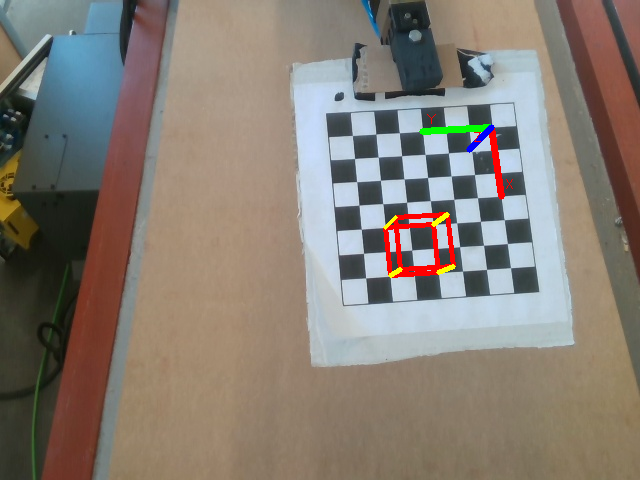

In [23]:
# Show result
cv2_imshow(image)

7. Test robot-camera calibration

In [24]:
# Define axis and box coordinates in camera coordinate system
box = np.float32([[-0.1, -0.6, 0], [-0.1, -0.7, 0], [-0.2, -0.7, 0], 
                  [-0.2, -0.6, 0], [-0.1, -0.6, -0.1], [-0.1, -0.7, -0.1], [-0.2, -0.7, -0.1], 
                  [-0.2, -0.6, -0.1]]).reshape(-1, 3)

In [25]:
# Retrieve rotation matrix and translation vector from bc_transform
cb_transform = invert_transform(bc_transform)
cb_rot = cb_transform[:3, :3]
cb_trans = cb_transform[0:3, 3]

In [26]:
# Project 3D box points to pixel coordinates
imgpts_box, _ = cv2.projectPoints(box, cb_rot, cb_trans, mtx, dist)

# Draw box on image
image = draw_box1(image, imgpts_box)

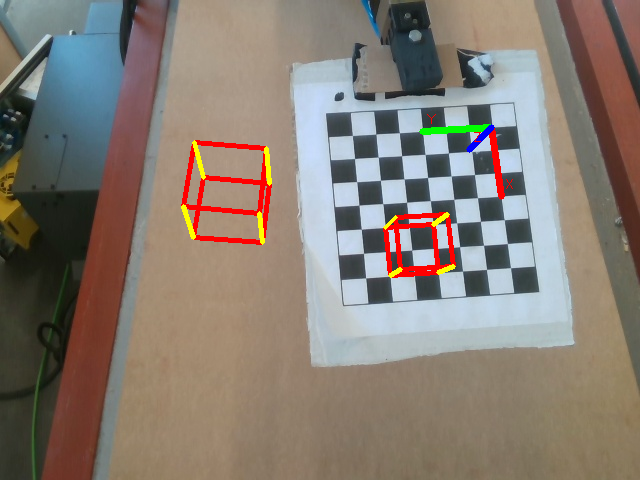

In [27]:
# Show result
cv2_imshow(image)